#TODO
- Compare algos to
    - experimental results
    - NIH web site

In [1]:
from typing import Iterable
import datetime
from collections import Counter
import statistics

In [250]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdDepictor
from rdkit import RDLogger
from rdkit.Chem import Draw, rdFMCS, MCS
import rdkit
from rdkit.Chem.MolStandardize import rdMolStandardize
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print(rdkit.__version__)

2023.09.1


In [3]:
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [4]:
def enumerate_tauts(sml):
    enumerators = [rdMolStandardize.TautomerEnumerator(), rdMolStandardize.GetV1TautomerEnumerator()]
    smls_tauts = [{} for _ in enumerators]
    for i, enumerator in enumerate(enumerators):
        mol = Chem.MolFromSmiles(sml)
        tauts = enumerator.Enumerate(mol)
        for taut in tauts:
            smls_tauts[i].update({Chem.MolToSmiles(taut):taut})
    return smls_tauts

In [5]:
def check_same_keys(dict_list):
    start = datetime.datetime.now()
    # Check if the list is empty or has only one dictionary
    if len(dict_list) < 2:
        return True

    # Get the keys of the first dictionary in the list
    reference_keys = set(dict_list[0].keys())

    # Iterate through the dictionaries starting from the second one
    for dictionary in dict_list[1:]:
        # Check if the keys of each dictionary match the keys of the reference dictionary
        if set(dictionary.keys()) != reference_keys:
            # Return False if keys are not the same
            return False
    # Return True if all dictionaries have the same keys
    # print(f"check_same_keys took {datetime.datetime.now() - start} seconds")
    return True

Algorithm for processing Tautomer_database_release_3a:
1) Remove duplicate (keep only one row) Ref values--at initial inspection, seems like duplicate rows contain the same SMILES for SMILES_n OR keep all rows for a Ref, putting all the SMILES into a set 
2) For each row corresponding to a Ref,
    1) Read Size value
    2) Extract columns SMILES_n where n = 1 to Size
    3) Convert extracted SMILES_n to canonical using RDKit
    4) Use those several SMILES_n columns as experimental tautomers by creating a set of SMILES_n (or dictionary of SMILES_n:mol ?)
    5) Use only SMILES_1 to enumerate tautomers using various cheminformatics algorithms
    6) Compare experimental to cheminformatics results: Are there differences in count and canonical SMILES?

In [6]:
# Tautomer database from https://cactus.nci.nih.gov/download/tautomer/
file_name = "../data/Tautomer_database_release_3a.xlsx"
# file_name = "../data/Tautomer_database_release_3a_first.xlsx" # Only the first row, for speedy debugging
sheet_name = "Tautomer_database"
# file_name = "../data/8.sk.smi"
# file_name = "../data/12.sk.smi"

In [7]:
def canon_sml_or_none(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol)

In [9]:
df = pl.read_excel(
    source=file_name, 
    sheet_name=sheet_name,
    read_csv_options={"infer_schema_length":10000},
    )

# Lists for names of SMILES_n and InChI_n columns
SMILES_columns = [col for col in df.columns if col.startswith('SMILES_')]
InChI_columns = [col for col in df.columns if col.startswith('Std_InChI_')]

# Combined list of SMILES_n and InChI_n columns
numbered_columns = [elem for pair in zip(SMILES_columns, InChI_columns) for elem in pair]

# Select relevant columns in dataframe
df = df.select("Ref","Size",*numbered_columns)

# Melt dataframe: Break out each row's SMILES_n columns into its own row
df_melted = df.melt(id_vars=["Ref","Size"], value_vars=SMILES_columns, value_name="sml")

# Keep rows where SMILES is supplied
df_melted = df_melted.filter(pl.col('sml').is_not_null())

df_melted = df_melted.drop("variable")

# Remove duplicate rows, which are possible because a Ref can have multiple rows
df_melted = df_melted.unique()

# Add the RDKit molecule
#TODO Break this out into a function so can try with normalize(?) = False
df_melted = df_melted.with_columns(
    [
        pl.col("sml").map_elements(lambda s: Chem.MolFromSmiles(s)).alias("mol"),
    ]
)

# Add the canonical SMILES
df_melted = df_melted.with_columns(
    [
        pl.col("mol").map_elements(lambda m: canon_sml_or_none(m)).alias("canon_sml"),
    ]
)
# print("df_melted, Ref=4")
# print(df_melted.filter(pl.col("Ref") == 4))

# Remove the input SMILES column; drop rows with any null values
df_melted = df_melted.drop("sml").drop_nulls()

# Drop duplicate (Ref + canonical SMILES) rows
df_melted = df_melted.unique(["Ref", "canon_sml"])

df_melted = df_melted.sort("Ref")
with pl.Config(fmt_str_lengths=1000):
    print(df_melted)

shape: (3_789, 4)
┌──────┬──────┬──────────────────────────────────┬─────────────────────────────────────────────────┐
│ Ref  ┆ Size ┆ mol                              ┆ canon_sml                                       │
│ ---  ┆ ---  ┆ ---                              ┆ ---                                             │
│ i64  ┆ i64  ┆ object                           ┆ str                                             │
╞══════╪══════╪══════════════════════════════════╪═════════════════════════════════════════════════╡
│ 1    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)CC(C)=O                                   │
│      ┆      ┆ 0x175ef7990>                     ┆                                                 │
│ 1    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ CC(=O)/C=C(/C)O                                 │
│      ┆      ┆ 0x175eeb760>                     ┆                                                 │
│ 2    ┆ 2    ┆ <rdkit.Chem.rdchem.Mol object at ┆ c1c[nH]nn1            

In [10]:
df_melted.filter(pl.col("Ref") == 4)

Ref,Size,mol,canon_sml
i64,i64,object,str


In [11]:
def smls_tauts(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_dict = dict()
    for taut in tauts:
        tauts_dict.update({Chem.MolToSmiles(taut):taut})
    return tauts_dict

In [12]:
def tauts_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_list = []
    for taut in tauts:
        tauts_list.append(taut)
    return tauts_list

In [13]:
def tauts_as_sml_list(
        enumerator,
        mol,
    ):
    tauts = enumerator.Enumerate(mol)
    tauts_as_sml_list = []
    for taut in tauts:
        tauts_as_sml_list.append(Chem.MolToSmiles(taut))
    
    # Make smls into a set to remove duplicates, then back into a list so can be in dataframe
    tauts_as_sml_list = list(set(tauts_as_sml_list))
    return tauts_as_sml_list

In [14]:
# Enumerate tautomers--this may take more than one minute
enumerators = [rdMolStandardize.TautomerEnumerator, rdMolStandardize.GetV1TautomerEnumerator]
for i, enumerator in enumerate(enumerators):
    df_melted = df_melted.with_columns(
        [
            pl.col("mol").map_elements(lambda m: tauts_as_sml_list(enumerator(), m)).alias("tauts" + enumerator.__name__),
        ]
    )

In [82]:
# Manually list tautomers created by NIH Tautomerizer
# https://cactus.nci.nih.gov/cgi-bin/tautomerize.tcl
nih_sml_tauts = {
    "COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O": [
        "COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O",
        "COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O",
        "COC3=C2[C@H]([C@@H](C1=C(OC)C(=C6C5=C1C2=C4C(=C3O)C(C=C(C4=C5C(=CC6=O)OC)OC)=O)O)[C@H](C)O)[C@H](C)O",
        "COC2=C3[C@H]([C@@H](C4=C(OC)C(=O)C6=C5C(=C1C(C(=C(C=C1OC)O)C2=O)C3=C45)C(=CC6=O)OC)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5=C3C1=C2C(=C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O",
        "COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O",
    ],
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1": [
        "CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=C)N2",
        "CSC1=NC(C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)=C",
        "CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C",
        "CSC1NC(=C(C(=N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C",
        "CSC2=NC(=C1C(C=CC=C1)=[N+]([O-])O)C(=C(C)N2)C(=O)OC(C)C",
        "CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C",
    ],
}

In [189]:
# Function to canonicalize a list of SMILES
def canonicalize_smiles(smiles_list):
    canonical_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            canonical = Chem.MolToSmiles(mol)
            canonical_smiles.append(canonical)
            print(f"{smiles == canonical=}")
        else:
            mol = Chem.MolFromSmiles(smiles, sanitize=False)
            if mol:
                canonical = Chem.MolToSmiles(mol)
                canonical_smiles.append(canonical)
                print(f"{smiles == canonical}")
            else:
                canonical_smiles.append(None)
                print("Molecule couldn't be created")
    return canonical_smiles

In [190]:
nih_sml_tauts_canon = {key: canonicalize_smiles(value) for key, value in nih_sml_tauts.items()}
nih_sml_tauts_canon

smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False
smiles == canonical=False


{'COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O': ['COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)[C@@H]2[C@H](C)O)C1=O',
  'COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54',
  'COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O',
  'COC1=CC(=O)C2C(=O)C(OC)=C3c4c5c6c(c1c42)C(OC)=CC(=O)C6C(=O)C(OC)=C5[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O',
  'COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54',
  'COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O)C(=O)C=C1OC',
  'COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(O)c5c(=O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54',
  'COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54',
  'COC1=CC(=O)C2=C3C1=C1C(OC)=CC(O)=C4C(=O)C(OC)=C5C(=C3C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]5[C@

In [191]:
nih_inputs = nih_sml_tauts_canon.keys()
nih_tauts = nih_sml_tauts_canon.values()
df_nih = pl.DataFrame({"canon_sml": nih_inputs, "tautsNIH": nih_tauts})
df_nih

canon_sml,tautsNIH
str,list[str]
"""COc1c2c3c4c(c(…","[""COC1=C2c3c4c(c(O)cc(OC)c4c4c(OC)cc(O)c5c(O)c(OC)c(c3c54)=C([C@H](C)O)[C@@H]2[C@H](C)O)C1=O"", ""COc1c(O)c2c(O)cc(OC)c3c4c(OC)cc(O)c5c(O)c(OC)c6c([C@H](C)O)c([C@H](C)O)c1c(c23)c6c54"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)[C@@H]([C@H](C)O)[C@@H]3[C@H](C)O""]"
"""CSC1=NC(c2cccc…","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(=C2C=CCC=C2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]"


In [192]:
# Merge in NIH tauts by left-joining on canon_sml
df_melted = df_melted.join(df_nih, on="canon_sml", how="left").drop("tautsNIH_right")

In [193]:
df_melted.filter(pl.col("tautsNIH") != None)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,i64,object,str,list[str],list[str],list[str]
1,2,<rdkit.Chem.rdchem.Mol object at 0x175ef7990>,"""CC(=O)CC(C)=O""","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",[]
1,2,<rdkit.Chem.rdchem.Mol object at 0x175eeb760>,"""CC(=O)/C=C(/C)…","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",[]
2,2,<rdkit.Chem.rdchem.Mol object at 0x283207ed0>,"""c1c[nH]nn1""","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",[]
2,2,<rdkit.Chem.rdchem.Mol object at 0x175f18200>,"""c1cn[nH]n1""","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",[]
3,2,<rdkit.Chem.rdchem.Mol object at 0x175f30f20>,"""Cc1ccn[nH]1""","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""]",[]
3,2,<rdkit.Chem.rdchem.Mol object at 0x175ecfb50>,"""Cc1cc[nH]n1""","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""]",[]
5,3,<rdkit.Chem.rdchem.Mol object at 0x175f4bbc0>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]",[]
5,3,<rdkit.Chem.rdchem.Mol object at 0x175edfca0>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]",[]
5,3,<rdkit.Chem.rdchem.Mol object at 0x283207f40>,"""CC1(C)[C@@H]2C…","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]","[""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2=CO"", ""CC1(C)[C@@H]2CC[C@]1(C)C(=O)C2C=O"", ""CC1(C)[C@@H]2CC[C@]1(C)C(O)=C2C=O""]",[]


In [194]:
# Replace None (null) values in tautsNIH to prevent error when flatten nested list into non-nested (flat) list
tautsNIH = df_melted["tautsNIH"].to_list()
tautsNIH_no_nulls = [val if val is not None else [] for val in tautsNIH]
tautsNIH_no_nulls_series = pl.Series(tautsNIH_no_nulls)
df_melted = df_melted.with_columns(tautsNIH_no_nulls_series.alias("tautsNIH"))

In [195]:
# Merge tautomer smls for each row for same ref: 
#   assumption is that all input smls correspond to legitimate tautomers
other_columns = [col for col in df_melted.columns if col not in ['Ref']]

df_melted_aggregated = (
    df_melted.group_by('Ref')
    .agg(*other_columns)
)
df_melted_aggregated.head(3)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""CC(=O)CC(C)=O"", ""CC(=O)/C=C(/C)O""]","[[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[], []]"
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[], []]"
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""], [""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]]","[[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""], [""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""]]","[[], []]"


In [196]:
#Debugging: Inspect row where NIH tautomers added
df_melted_aggregated.filter(pl.col("Ref").is_in([888, 889]))

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]]
888,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O""]","[[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)C([C@H](C)O)C3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)C([C@H](C)O)C3[C@H](C)O""], [""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)C([C@H](C)O)C3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c6c(O)cc(OC)c2c6c54)=C(OC)C(=O)C3=C(O)C1""]]","[[""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", ""COC1=c2c3c4c5c(c(C(C)O)c(C(C)=O)c6c5c2=C(C(=O)C1)C(=O)C6OC)C(OC)C(=O)C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(=O)CC=5OC)C(OC)C=C(O)C4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(=C(C)O)c(=C(C)O)c4c(OC)c(O)c5c6c(c1c2c3c64)C(OC)CC=5O"", ""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)C=C(O)C4C(=O)C=2OC""]]","[[], [""COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O"", ""COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O"", … ""COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O""]]"
889,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@H]([C@@H](C)O)[C@H]6[C@@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H]([C@@H](C)O)[C@H]2[C@@H](C)O""]","[[""COC1=c2c3c4c(c(O)c(OC)c5c([C@@H](C)O)c([C@@H](C)O)c6c(OC)c(O)c(c2c6c54)C(=O)C1)C(=O)CC=3OC"", ""COC1=CC(=O)C2=C(O)C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)C4=C(OC)C(=O)C5C(=O)C=C(OC)c6c1c2c3c4c65"", … ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)=C(OC)CC5=O""], [""COC1=c2c3c4c(c([C@@H](C)O)c([C@@H](C)O)c5c4c4c2=C(OC)CC(=O)C4C(=O)C=5OC)=C(OC)C(=O)C3C(O)=C1"", ""COC1=c2c3c4c(c([C@@H](C)O)c([C@@H](C)O)c5c(OC)c(O)c6c(c2=C(OC)CC6=O)c54)=C(OC)C(=O)C3C(O)=C1"", … ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)=C(OC)CC5=O""]]","[[""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", ""COC1=c2c3c4c5c(c(C(C)O)c(C(C)=O)c6c5c2=C(C(=O)C1)C(=O)C6OC)C(OC)C(=O)C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(=O)CC=5OC)C(OC)C=C(O)C4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(=C(C)O)c(=C(C)O)c4c(OC)c(O)c5c6c(c1c2c3c64)C(OC)CC=5O"", ""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)C=C(O)C4C(=O)C=2OC""]]","[[], []]"


In [197]:
# For each tautomers column, created a flattened column to merge same canonical SMILES

# List of columns with tautomers
tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('tauts')]
# tauts_columns = [col for col in tauts_columns if col not in ['tautsNIH']]
print(tauts_columns)
for tauts_column in tauts_columns:
    print(tauts_column)
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(tauts_column).map_elements(lambda m: list(set([item for row in m for item in row]))).alias("flat_" + tauts_column),
        ]
    )
df_melted_aggregated.head(3)

['tautsTautomerEnumerator', 'tautsGetV1TautomerEnumerator', 'tautsNIH']
tautsTautomerEnumerator
tautsGetV1TautomerEnumerator
tautsNIH


Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str]
1,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""CC(=O)CC(C)=O"", ""CC(=O)/C=C(/C)O""]","[[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""], [""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]]","[[], []]","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]","[""C=C(O)CC(=C)O"", ""C=C(O)CC(C)=O"", … ""C=C(O)C=C(C)O""]",[]
2,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[""c1c[nH]nn1"", ""c1cn[nH]n1""], [""c1c[nH]nn1"", ""c1cn[nH]n1""]]","[[], []]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]","[""c1c[nH]nn1"", ""c1cn[nH]n1""]",[]
3,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""], [""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]]","[[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""], [""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""]]","[[], []]","[""Cc1ccn[nH]1"", ""Cc1cc[nH]n1""]","[""C=C1C=CNN1"", ""Cc1ccn[nH]1"", … ""C=C1CC=NN1""]",[]


Hi

In [198]:
# Add tautomer counts

# Create list of flat tautomer columns
flat_tauts_columns = [col for col in df_melted_aggregated.columns if col.startswith('flat_tauts')]

# Add tautomers from Tautomer database
flat_tauts_columns.append("canon_sml")
for flat_tauts_column in flat_tauts_columns:
    df_melted_aggregated = df_melted_aggregated.with_columns(
        [
            pl.col(flat_tauts_column).map_elements(lambda t: len(t)).alias("n_" + flat_tauts_column.replace("flat_", "")),
        ]
    )
df_melted_aggregated.drop(["tautsNIH","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(pl.col("n_canon_sml") > 4)

Ref,Size,mol,canon_sml,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml
i64,list[i64],list[extension],list[str],list[str],list[str],list[str],i64,i64,i64,i64
926,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CCOC(=O)CC(=O)C/C(O)=C/C(=O)OC"", ""CCOC(=O)/C=C(\O)C/C(O)=C/C(=O)OC"", … ""CCOC(=O)C/C(O)=C/C(=O)CC(=O)OC""]","[""CCOC(O)=CC(O)=CC(=O)C=C(O)OC"", ""CCOC(O)=CC(=O)CC(=O)CC(=O)OC"", … ""CCOC(O)=CC(O)=CC(O)=CC(=O)OC""]","[""CCOC(O)=CC(O)=CC(=O)C=C(O)OC"", ""CCOC(O)=CC(=O)CC(=O)CC(=O)OC"", … ""CCOC(O)=CC(O)=CC(O)=CC(=O)OC""]",[],21,21,0,5
927,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CCOC(=O)C/C(O)=C(\CC)C(=O)CC(=O)OC"", ""CCOC(=O)CC(=O)C(CC)C(=O)CC(=O)OC"", … ""CCOC(=O)/C=C(\O)C(CC)C(=O)CC(=O)OC""]","[""CCOC(=O)CC(=O)C(CC)=C(O)C=C(O)OC"", ""CCOC(=O)CC(O)=C(CC)C(O)=CC(=O)OC"", … ""CCOC(=O)C=C(O)C(CC)=C(O)CC(=O)OC""]","[""CCOC(=O)CC(=O)C(CC)=C(O)C=C(O)OC"", ""CCOC(=O)CC(O)=C(CC)C(O)=CC(=O)OC"", … ""CCOC(=O)C=C(O)C(CC)=C(O)CC(=O)OC""]",[],21,21,0,5
928,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CCOC(=O)/C(C)=C(\O)C/C(O)=C/C(=O)OC"", ""CCOC(=O)C(C)/C(O)=C/C(=O)CC(=O)OC"", … ""CCOC(=O)/C(C)=C(\O)CC(=O)CC(=O)OC""]","[""CCOC(=O)C(C)C(=O)C=C(O)CC(=O)OC"", ""CCOC(O)=C(C)C(=O)C=C(O)C=C(O)OC"", … ""CCOC(O)=C(C)C(O)=CC(=O)C=C(O)OC""]","[""CCOC(=O)C(C)C(=O)C=C(O)CC(=O)OC"", ""CCOC(O)=C(C)C(=O)C=C(O)C=C(O)OC"", … ""CCOC(O)=C(C)C(O)=CC(=O)C=C(O)OC""]",[],21,21,0,5
929,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CC/C(C(=O)OC)=C(/O)C/C(O)=C/C(=O)OC"", ""CC/C(C(=O)OC)=C(/O)CC(=O)CC(=O)OC"", … ""CCC(C(=O)OC)/C(O)=C/C(=O)CC(=O)OC""]","[""CCC(C(=O)OC)=C(O)C=C(O)CC(=O)OC"", ""CCC(C(=O)OC)C(O)=CC(O)=CC(=O)OC"", … ""CCC(C(=O)OC)=C(O)C=C(O)C=C(O)OC""]","[""CCC(C(=O)OC)=C(O)C=C(O)CC(=O)OC"", ""CCC(C(=O)OC)C(O)=CC(O)=CC(=O)OC"", … ""CCC(C(=O)OC)=C(O)C=C(O)C=C(O)OC""]",[],21,21,0,5
930,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""COC(=O)CC(=O)CC(=O)C(Cl)C(=O)OC"", ""COC(=O)/C=C(\O)C/C(O)=C(\Cl)C(=O)OC"", … ""COC(=O)CC(=O)/C=C(\O)C(Cl)C(=O)OC""]","[""COC(=O)C(Cl)=C(O)C=C(O)C=C(O)OC"", ""COC(=O)CC(O)=CC(=O)C(Cl)C(=O)OC"", … ""COC(=O)CC(O)=CC(O)=C(Cl)C(=O)OC""]","[""COC(=O)C(Cl)=C(O)C=C(O)C=C(O)OC"", ""COC(=O)CC(O)=CC(=O)C(Cl)C(=O)OC"", … ""COC(=O)CC(O)=CC(O)=C(Cl)C(=O)OC""]",[],21,21,0,5
931,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CCOC(=O)/C(Cl)=C(\O)CC(=O)CC(=O)OC"", ""CCOC(=O)C(Cl)C(=O)CC(=O)CC(=O)OC"", … ""CCOC(=O)C(Cl)/C(O)=C/C(=O)CC(=O)OC""]","[""CCOC(=O)C(Cl)C(O)=CC(O)=CC(=O)OC"", ""CCOC(=O)C(Cl)C(O)=CC(=O)C=C(O)OC"", … ""CCOC(=O)C(Cl)C(=O)C=C(O)C=C(O)OC""]","[""CCOC(=O)C(Cl)C(O)=CC(O)=CC(=O)OC"", ""CCOC(=O)C(Cl)C(O)=CC(=O)C=C(O)OC"", … ""CCOC(=O)C(Cl)C(=O)C=C(O)C=C(O)OC""]",[],21,21,0,5
932,"[5, 5, … 5]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>, … <rdkit.Chem.rdchem.Mol object at 0x175f30f20>]","[""CCOC(=O)/C(F)=C(\O)CC(=O)CC(=O)OC"", ""CCOC(=O)/C(F)=C(\O)C/C(O)=C/C(=O)OC"", … ""CCOC(=O)C(F)C(=O)C/C(O)=C/C(=O)OC""]","[""CCOC(=O)C(F)C(=O)CC(=O)C=C(O)OC"", ""CCOC(=O)C(F)=C(O)C=C(O)C=C(O)OC"", … ""CCOC(=O)C(F)C(=O)C=C(O)CC(=O)OC""]","[""CCOC(=O)C(F)C(=O)CC(=O)C=C(O)OC"", ""CCOC(=O)C(F)=C(O)C=C(O)C=C(O)OC"", … ""CCOC(=O)C(F)C(=O)C=C(O)CC(=O)OC""]",[],21,21,0,5
1213,"[5, 5, … 5]","[<

In [199]:
def sets_are_equal(
        *iterables: Iterable,
):
    if len(iterables) < 2:
        return True

    # Convert iterables into sets
    iterables_list = [iterable for iterable in iterables]
    sets_list = [set(iterable) for iterable in iterables_list]

    # Get the keys of the first dictionary in the list
    reference_set = sets_list[0]

    # Iterate through the sets starting from the second one
    for this_set in sets_list[1:]:
        # Check if each set matches the reference set
        if this_set != reference_set:
            return False  # Return False if keys are not the same
    return True  # Return True if all dictionaries have the same keys

In [200]:
# Check if sets of tautomers are the same for different algorithms
df_melted_aggregated = df_melted_aggregated.with_columns(
    [
        # Check if different algos produce same set of tautomers
        pl.struct(["flat_tautsTautomerEnumerator", "flat_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: sets_are_equal(x["flat_tautsTautomerEnumerator"], x["flat_tautsGetV1TautomerEnumerator"]))
        .alias("tauts_same"),
        # Calculate difference in number of tautomers between algos
        pl.struct(["n_tautsTautomerEnumerator", "n_tautsGetV1TautomerEnumerator"]).
        map_elements(lambda x: x["n_tautsTautomerEnumerator"] - x["n_tautsGetV1TautomerEnumerator"])
        .alias("n_tauts_diff"),
    ]
)
df_melted_aggregated.filter(abs(pl.col("n_tauts_diff")) > 300)

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
888,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@@H]([C@H](C)O)[C@@H]6[C@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@@H]([C@H](C)O)[C@@H]2[C@H](C)O""]","[[""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)C([C@H](C)O)C3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC"", … ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c(OC)cc(O)c2c1c4C(=C(OC)C2=O)C([C@H](C)O)C3[C@H](C)O""], [""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)C([C@H](C)O)C3[C@H](C)O)C(=O)C=C1OC"", ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c6c(O)cc(OC)c2c6c54)=C(OC)C(=O)C3=C(O)C1""]]","[[""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", ""COC1=c2c3c4c5c(c(C(C)O)c(C(C)=O)c6c5c2=C(C(=O)C1)C(=O)C6OC)C(OC)C(=O)C4C(=O)CC3OC"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1C(OC)C(=O)C=6C(=O)CC=5OC)C(OC)C=C(O)C4C(=O)C2OC""], [""COc1cc(O)c2c(O)c(OC)c3c(=C(C)O)c(=C(C)O)c4c(OC)c(O)c5c6c(c1c2c3c64)C(OC)CC=5O"", ""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)C=C(O)C4C(=O)C=2OC""]]","[[], [""COC4=C1[C@H](C(=C6C2=C5C(=C3C(=C12)C(=C(C=C3OC)O)C4=O)C(=CC(=C5C(=C6OC)O)O)OC)[C@H](C)O)[C@H](C)O"", ""COC1=C(C2=C(C=C(C3=C5C(=CC(=C6C(=C(C4=C([C@H](C)O)C(=C1C(=C23)C4=C56)[C@H](C)O)OC)O)O)OC)OC)O)O"", … ""COC6=C2[C@H]([C@@H](C1=C(OC)C(=O)C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)[C@H](C)O)[C@H](C)O""]]","[""COC1=CC(=O)C2C(=O)C(OC)c3c([C@H](C)O)c([C@H](C)O)c4c5c6c(c1c2c35)=C(OC)CC(=O)C=6C(=O)C4OC"", ""COC1=CC(=O)C2C(=O)C(OC)=C3c4c2c1c1c2c(c(O)c(OC)c(c42)C([C@H](C)O)C3[C@H](C)O)C(=O)C=C1OC"", … ""COC1=c2c3c4c(c([C@H](C)O)c([C@H](C)O)c5c(OC)c(O)c6c(O)cc(OC)c2c6c54)=C(OC)C(=O)C3=C(O)C1""]","[""COc1cc(O)c2c(O)c(OC)c3c(=C(C)O)c(=C(C)O)c4c(OC)c(O)c5c6c(c1c2c3c64)C(OC)CC=5O"", ""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c(c2c3c45)C(=C(O)CC6OC)C1=O"", … ""C=C(O)c1c(C(C)O)c2c3c4c(c5c6c3c1=C(OC)C(=O)C6C(O)=CC5OC)C(OC)C=C(O)C4C(=O)C=2OC""]","[""COC6=C1[C@H]([C@@H](C5C3=C1C2=C(C(C=C(C2=C4C(=CC(C(=C34)C(=C5OC)O)=O)OC)OC)=O)C6=O)[C@H](C)O)[C@H](C)O"", ""COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(C(C=C(C3=C4C(=CC5=O)OC)OC)=O)C6=O)O)[C@H](C)O)[C@H](C)O"", … ""COC6=C2[C@H]([C@@H](C1=C(OC)C(=C5C4=C1C2=C3C(=C(C=C(C3=C4C(=CC5=O)OC)OC)O)C6=O)O)[C@H](C)O)[C@H](C)O""]",107,656,10,2,false,-549
889,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""COc1c(O)c2c(=O)cc(OC)c3c4c(OC)cc(=O)c5c(O)c(OC)c6c(c(c1[C@H]([C@@H](C)O)[C@H]6[C@@H](C)O)c23)c54"", ""COc1c2c3c4c(c(OC)c(=O)c5c(O)cc(OC)c(c6c(OC)cc(O)c(c1=O)c63)c54)[C@H]([C@@H](C)O)[C@H]2[C@@H](C)O""]","[[""COC1=c2c3c4c(c(O)c(OC)c5c([C@@H](C)O)c([C@@H](C)O)c6c(OC)c(O)c(c2c6c54)C(=O)C1)C(=O)CC=3OC"", ""COC1=CC(=O)C2=C(O)C(OC)C3=C([C@@H](C)O)C([C@@H](C)O)C4=C(OC)C(=O)C5C(=O)C=C(OC)c6c1c2c3c4c65"", … ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)=C(OC)CC5=O""], [""COC1=c2c3c4c(c([C@@H](C)O)c([C@@H](C)O)c5c4c4c2=C(OC)CC(=O)C4C(=O)C=5OC)=C(OC)C(=O)C3C(O)=C1"", ""COC1=c2c3c4c(c([C@@H](C)O)c([C@@H](C)O)c5c(OC)c(O)c6c(c2=C(OC)CC6=O)c54)=C(OC)C(=O)C3C(O)=C1"", … ""COC1=CC(=O)C2C(=O)C(OC)c3c([C@@H](C)O)c([C@@H](C)O)c4c(OC)c(O)c5c6c(c1c2c3c46)=C(OC)CC5=O""]]","[[""COC1=c2c(=C(C)O)c(C(C)O)c3c(OC)c(O)c4c(O)cc(OC)c5c6c

In [201]:
# Narrow down to rows where algos give different sets of tautomers
df_melted_aggregated_different = df_melted_aggregated.filter(pl.col("tauts_same") == False)

df_melted_aggregated_different.drop(["mol","tautsTautomerEnumerator", "tautsGetV1TautomerEnumerator"]).filter(abs(pl.col("n_tauts_diff")) < 5).sort(abs(pl.col("n_tauts_diff")), descending=True).head(7)

Ref,Size,canon_sml,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[str],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
73,"[2, 2]","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]","[[], [""CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C"", ""CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C"", … ""CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C""]]","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1""]","[""CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C"", ""CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C"", … ""CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C""]",4,8,8,2,false,-4
76,"[2, 2]","[""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1"", ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1""]","[[], []]","[""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1"", ""CCOC(O)=C1C(C)=NC(OC)=NC1c1ccccc1"", … ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1""]","[""CCOC(O)=C1C(C)=NC(OC)=NC1c1ccccc1"", ""C=C1N=C(OC)NC(c2ccccc2)C1=C(O)OCC"", … ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1""]",[],4,8,0,2,false,-4
77,"[2, 2]","[""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1Cl"", ""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1Cl""]","[[], []]","[""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1Cl"", ""CCOC(=O)C1C(C)=NC(OC)=NC1c1ccccc1Cl"", … ""CCOC(=O)C1=C(C)NC(OC)=NC1c1ccccc1Cl""]","[""CCOC(=O)C1=C(C)N=C(OC)NC1c1ccccc1Cl"", ""C=C1NC(OC)=NC(c2ccccc2Cl)C1=C(O)OCC"", … ""C=C1N=C(OC)NC(c2ccccc2Cl)C1C(=O)OCC""]",[],4,8,0,2,false,-4
80,"[2, 2]","[""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])NC(C(F)(F)F)=N1"", ""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N=C(C(F)(F)F)N1""]","[[], []]","[""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])NC(C(F)(F)F)=N1"", ""CC1=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N=C(C(F)(F)F)N1"", … ""CC1=NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C""]","[""C=C1NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C"", ""C=C1NC(C(F)(F)F)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", … ""C=C1N=C(C(F)(F)F)NC(c2ccccc2[N+](=O)[O-])C1=C(O)OC(C)C""]",[],4,8,0,2,false,-4
115,"[2, 2]","[""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3"", ""NC1=c2c(nc3n2Cc2ccccc2-3)=NS(=O)(=O)N1""]","[[], []]","[""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3"", ""NC1=c2c(nc3n2Cc2ccccc2-3)=NS(=O)(=O)N1"", ""N=C1NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3""]","[""NC1=c2c(nc3c4ccccc4cn23)NS(=O)(=O)N1"", ""NC1=NS(=O)(=O)Nc2nc3n(c21)Cc1ccccc1-3"", … ""N=C1NS(=O)(=O)Nc2[nH]c3c4ccccc4cn3c21""]",[],3,7,0,2,false,-4
149,"[3, 3, 3]","[""CCOC(=O)c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12"", ""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""CCOC(=O)c1cnn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]","[[], [], []]","[""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4NC3=O)cnc12"", ""CCOC(=O)C1C=Nn2c1ncc(-c1nc3ccccc3nc1O)c2=O"", … ""CCOC(O)=c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]","[""CCOC(=O)c1cnn2c(=O)c(=C3Nc4ccccc4NC3=O)cnc12"", ""CCOC(=O)c1c[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", … ""CCOC(O)=c1cnn2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]",[],14,10,0,3,false,4
151,"[3, 3, 3]","[""COC(=O)c1c(N)nn2c(=O)c(-c3nc4ccccc4[nH]c3=O)c[nH]c12"", ""COC(=O)c1c(N)[nH]n2c(=O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""COC(=O)c1c(N)nn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12""]","[[], [], []]","[""COC(=O)c1c(N)nn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""COC(=O)c1c(=N)[nH]n2c(O)c(-c3nc4ccccc4nc3O)cnc12"", … ""COC(=O)C1C(=N)Nn2c1ncc(-c1nc3ccccc3nc1O)c2=O""]","[""COC(=O)c1c(N)nn2c(O)c(-c3nc4ccccc4[nH]c3=O)cnc12"", ""COC(=O)c1c(=N)[nH]n2c(O)c(-c3nc4ccccc4nc3O)cnc12"", … ""COC(=O)C1C(=N)Nn2c1ncc(-c1nc3ccccc3nc1O)c2=O""]",[],26,22,0,3,false,4


In [202]:
def second_highest_frequency(lst):
    # Count frequencies of elements in the list
    frequencies = Counter(lst)
    
    # Find the second highest frequency
    unique_frequencies = sorted(set(frequencies.values()), reverse=True)
    
    # Find the second highest frequency value(s)
    second_highest_freq = unique_frequencies[1] if len(unique_frequencies) > 1 else unique_frequencies[0]
        
    return second_highest_freq

In [203]:
n_tauts_diff = df_melted_aggregated["n_tauts_diff"].to_list()
n_tauts_diff_no_zeros = [diff for diff in n_tauts_diff if diff != 0]
n_tauts_diff_positive = [diff for diff in n_tauts_diff_no_zeros if diff > 0]
n_tauts_diff_negative = [diff for diff in n_tauts_diff_no_zeros if diff < 0]
print(f"{len(n_tauts_diff)=}")
print(f"{len(n_tauts_diff_no_zeros)=}")
print(f"{len(n_tauts_diff_positive)=}")
print(f"{len(n_tauts_diff_negative)=}")

statistics.mean(n_tauts_diff)

len(n_tauts_diff)=1773
len(n_tauts_diff_no_zeros)=545
len(n_tauts_diff_positive)=136
len(n_tauts_diff_negative)=409


-4.641285956006768

In [204]:
def stats_for_list(
        my_list
):
    stats = {"mean":statistics.mean(my_list), "median":statistics.median(my_list), "mode":statistics.mode(my_list), "std dev":statistics.stdev(my_list)}
    for stat, value in stats.items():
        if stat in ["mean", "std dev"]:
            print(f"{stat:10} {value:.2f}")
        else:
            print(f"{stat:10} {value:}")
    return stats

In [205]:
stats_for_list(n_tauts_diff_no_zeros)

mean       -15.10
median     -2
mode       -1
std dev    52.94


{'mean': -15.09908256880734,
 'median': -2,
 'mode': -1,
 'std dev': 52.93827304354802}

In [206]:
stats_for_list(n_tauts_diff_positive)

mean       6.96
median     1.0
mode       1
std dev    28.32


{'mean': 6.955882352941177,
 'median': 1.0,
 'mode': 1,
 'std dev': 28.321662340586663}

In [207]:
stats_for_list(n_tauts_diff_negative)

mean       -22.43
median     -4
mode       -1
std dev    57.05


{'mean': -22.43276283618582,
 'median': -4,
 'mode': -1,
 'std dev': 57.05394765985538}

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


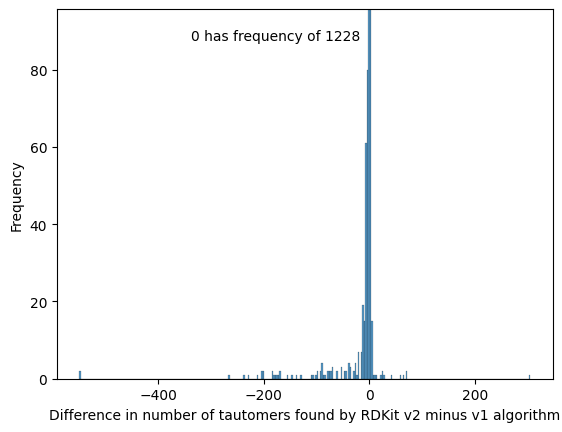

In [208]:
# Plot histogram of n_tauts_diff

sns.histplot(n_tauts_diff, bins=300)  # Adjust bins as needed
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
# plt.title('Histogram using Seaborn')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(0, largest_y_value, f'0 has frequency of {frequency_at_zero}  ', ha='right', va='bottom')

plt.show()


/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


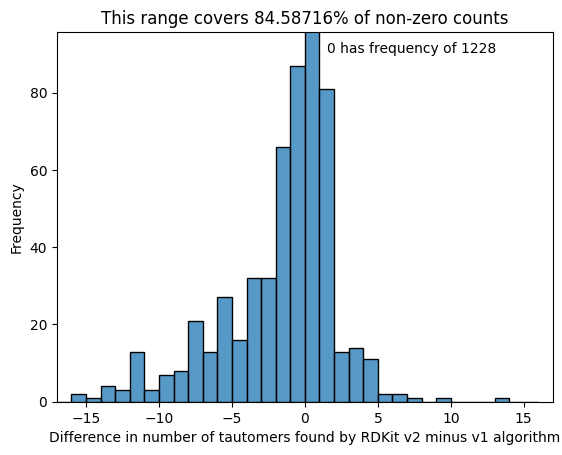

In [209]:
# Plot histogram of n_tauts_diff

x_len = 17
bins = range(-1 * x_len, x_len, 1)

n_tauts_diff_no_zeros_this_range = [diff for diff in n_tauts_diff_no_zeros if abs(diff) <= x_len]

non_zero_counts_this_range = len(n_tauts_diff_no_zeros_this_range) / len(n_tauts_diff_no_zeros)

sns.histplot(n_tauts_diff, bins=bins)
plt.xlabel('Difference in number of tautomers found by RDKit v2 minus v1 algorithm')
plt.ylabel('Frequency')
plt.title(f'This range covers {non_zero_counts_this_range:.5%} of non-zero counts')
largest_y_value = second_highest_frequency(n_tauts_diff)

plt.ylim(0, largest_y_value * 1.1)

plt.xlim(-1 * x_len, x_len)

# Find the frequency at n_tauts_diff = 0
frequency_at_zero = n_tauts_diff.count(0)

# Annotate the plot with the frequency at n_tauts_diff = 0
plt.text(1.5, largest_y_value * 1.03, f'0 has frequency of {frequency_at_zero}', ha='left', va='bottom')

plt.show()

In [210]:
second_highest_frequency(n_tauts_diff)

87

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:111

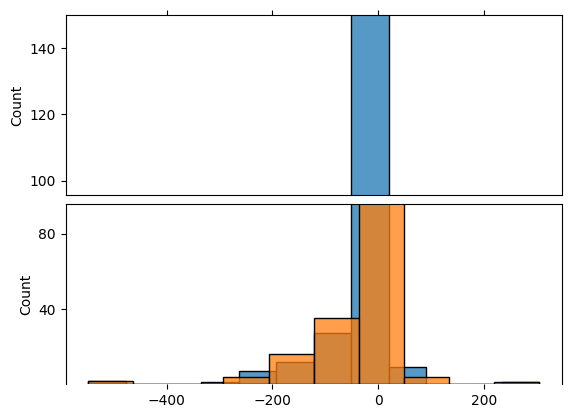

In [211]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)  # Adjust space between axes

# Plot the same data on both axes
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax1)  # Adjust bins as needed
sns.histplot(
    n_tauts_diff, 
    # bins=10, 
    ax=ax2)  # Adjust bins as needed

# Get the second-highest frequency
greatest_y_lower_plot = 1.1 * second_highest_frequency(n_tauts_diff)

# Set y-axis limits on both subplots
# max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax1).get_yticks()[1:])
ax2.set_ylim(0, greatest_y_lower_plot)

# Adjust the y-axis limit on the second plot to create a break
max_val = max(sns.histplot(n_tauts_diff, bins=10, ax=ax2).get_yticks()[1:])
ax1.set_ylim(greatest_y_lower_plot, max_val * 1.5)  # Adjust the range for the second plot

# Hide the overlapping portion of the y-axis between the two plots
ax2.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Hide top x-axis labels on the first plot

# Set the y-axis break indicator line
ax1.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=3, prune='both'))

plt.show()

In [212]:
def align_lists(
        list1,
        list2,
        filler = "",
):
    """Align list2 under list1, using filler for items in list1 not in list2, 
    for example:
    
    input:
    list1: a,  b,  c
    list2: a,  d,  c,  e,  f

    output:
    list2: a, "",  c,  d,  e,  f
    """
    # Determine index for each element in list2:
    list_2_indices = []
    list2_index_max = len(list1) - 1
    for _, list2_item in enumerate(list2):
        try:
            list2_index = list1.index(list2_item)
        except:
            list2_index_max += 1
            list2_index = list2_index_max
        list_2_indices.append(list2_index)

    # Create "empty" (all filler) list2 aligned--may be longer than list2 due to blank spaces
    list2_aligned = [filler] * (max(list_2_indices) + 1)

    # Slot in items from list2 to overwrite filler entries
    for i, list_2_col in enumerate(list_2_indices):
        list2_aligned[list_2_col] = list2[i]

    return list2_aligned

In [213]:
df_melted_aggregated_different_example = df_melted_aggregated_different.filter(pl.col("Ref") == 73)
df_melted_aggregated_different_example

Ref,Size,mol,canon_sml,tautsTautomerEnumerator,tautsGetV1TautomerEnumerator,tautsNIH,flat_tautsTautomerEnumerator,flat_tautsGetV1TautomerEnumerator,flat_tautsNIH,n_tautsTautomerEnumerator,n_tautsGetV1TautomerEnumerator,n_tautsNIH,n_canon_sml,tauts_same,n_tauts_diff
i64,list[i64],list[extension],list[str],list[list[str]],list[list[str]],list[list[str]],list[str],list[str],list[str],i64,i64,i64,i64,bool,i64
73,"[2, 2]","[<rdkit.Chem.rdchem.Mol object at 0x175ef7990>, <rdkit.Chem.rdchem.Mol object at 0x175eeb760>]","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]","[[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""], [""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]]","[[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1""], [""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1""]]","[[], [""CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C"", ""CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(C(=O)OC(C)C)C(=N2)C"", … ""CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C""]]","[""CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1""]","[""C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C"", ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1"", … ""CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1""]","[""CSC2=NC(=C1C(=CCC=C1)[N+]([O-])=O)C(=C(C)N2)C(=O)OC(C)C"", ""CSC2=NC(C1=C(C=CC=C1)[N+](=O)[O-])C(=C(O)OC(C)C)C(=N2)C"", … ""CSC1=NC(=C(C(N1)C2=C(C=CC=C2)[N+](=O)[O-])C(=O)OC(C)C)C""]",4,8,8,2,false,-4


In [266]:
smls_expt = df_melted_aggregated_different_example.select("canon_sml").item().to_list()
smls_nih = df_melted_aggregated_different_example.select("flat_tautsNIH").item().to_list()
smls_nih_aligned = align_lists(smls_expt, smls_nih)
smls_v2 = df_melted_aggregated_different_example.select("flat_tautsTautomerEnumerator").item().to_list()
smls_v2_aligned = align_lists(smls_nih_aligned, smls_v2)
smls_v1 = df_melted_aggregated_different_example.select("flat_tautsGetV1TautomerEnumerator").item().to_list()
smls_v1_aligned = align_lists(smls_v2_aligned, smls_v1)

tauts_expt = [Chem.MolFromSmiles(sml) for sml in smls_expt]
tauts_nih_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_nih_aligned]
tauts_v2_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_v2_aligned]
tauts_v1_aligned = [Chem.MolFromSmiles(sml) if sml else None for sml in smls_v1_aligned]

In [215]:
print(len(smls_expt + smls_nih + smls_v2 + smls_v1))

22


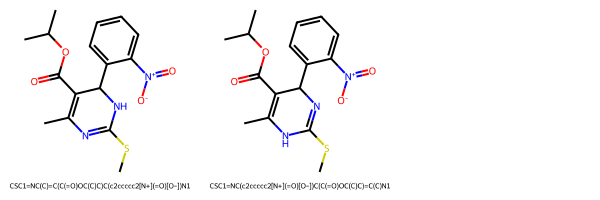

In [216]:
mcs = rdFMCS.FindMCS(tauts_expt)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_expt:
     _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
Draw.MolsToGridImage(tauts_expt, legends=smls_expt, useSVG=True, maxMols = 200)

mcs_smarts='[#6]-[#16]-[#6]1=,-[#7]-,=[#6](-,=[#6])=,-[#6](-[#6](-,=[#7]-,=1)-,=[#6]1:,-[#6]:,=[#6]:,-[#6]:,=[#6]:,-[#6]:,-1-,=[#7](=,-[#8])-[#8])-,=[#6](=,-[#8])-[#8]-[#6](-[#6])-[#6]'


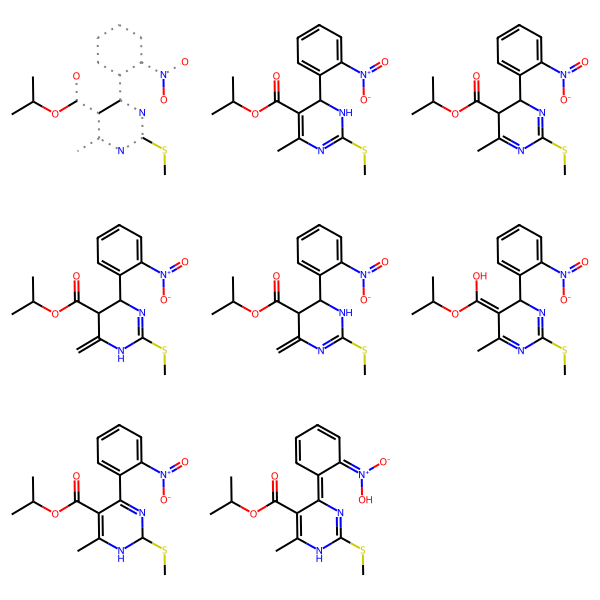

In [248]:
smls_nih_manual = [
    "CSC1=NC(C)=C(C(=O)OC(C)C)C(c2ccccc2[N+](=O)[O-])N1",
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)C(C)=N1",
    "C=C1NC(SC)=NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C",
    "C=C1N=C(SC)NC(c2ccccc2[N+](=O)[O-])C1C(=O)OC(C)C",
    "CSC1=NC(c2ccccc2[N+](=O)[O-])C(=C(O)OC(C)C)C(C)=N1",
    "CSC1N=C(c2ccccc2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1",
    "CSC1=NC(=C2C=CC=CC2=[N+]([O-])O)C(C(=O)OC(C)C)=C(C)N1",
    "CSC1=NC(=C2C=CCC=C2[N+](=O)[O-])C(C(=O)OC(C)C)=C(C)N1",
]
max_taut = 7
tauts_nih = [Chem.MolFromSmiles(sml) for sml in smls_nih_manual[0:max_taut]]
mcs = rdFMCS.FindMCS(
    tauts_nih,
    bondCompare=rdFMCS.BondCompare.CompareAny,
    )
mcs_smarts = mcs.smartsString
print(f"{mcs_smarts=}")
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_nih:
    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
mcs_mol
# mol_nih_manual = [Chem.MolFromSmiles(sml) for sml in smls_nih_manual[0 : max_taut + 1]]
mol_nih_manual = tauts_nih
Draw.MolsToGridImage([mcs_mol] + mol_nih_manual)

len(smls_expt + smls_nih)=10
len(tauts_all_flat)=10
tauts_all_flat=[<rdkit.Chem.rdchem.Mol object at 0x177315c40>, <rdkit.Chem.rdchem.Mol object at 0x175b35150>, <rdkit.Chem.rdchem.Mol object at 0x175b35930>, <rdkit.Chem.rdchem.Mol object at 0x175b35540>, <rdkit.Chem.rdchem.Mol object at 0x175b35af0>, <rdkit.Chem.rdchem.Mol object at 0x175b357e0>, <rdkit.Chem.rdchem.Mol object at 0x175b35770>, <rdkit.Chem.rdchem.Mol object at 0x175b358c0>, <rdkit.Chem.rdchem.Mol object at 0x175b35850>, <rdkit.Chem.rdchem.Mol object at 0x175b34820>]


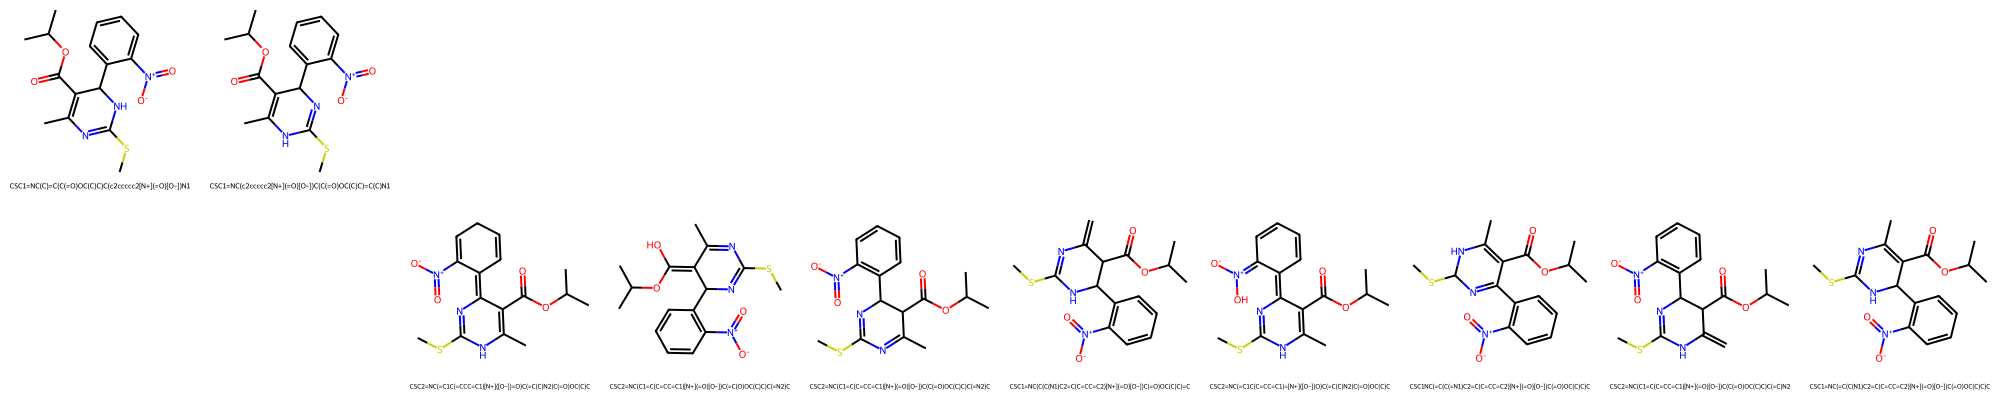

In [251]:
smls_matrix = [smls_expt, smls_nih_aligned]
tauts_matrix = [tauts_expt, tauts_nih_aligned]

# Exclude blank entries to avoid problem with aligning structures based on maximum common substructure (mcs)
smls_all_flat = smls_expt + smls_nih
tauts_all_flat = [Chem.MolFromSmiles(sml) for sml in smls_all_flat]
print(f"{len(smls_expt + smls_nih)=}")
print(f"{len(tauts_all_flat)=}")
print(f"{tauts_all_flat=}")

mcs = rdFMCS.FindMCS(
     tauts_all_flat, 
     bondCompare=rdFMCS.BondCompare.CompareAny,
     )
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all_flat:
     _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)
Draw.MolsMatrixToGridImage(tauts_matrix, legendsMatrix=smls_matrix, useSVG=True, maxMols = 200)

[<rdkit.Chem.rdchem.Mol object at 0x175c30430>, <rdkit.Chem.rdchem.Mol object at 0x175c30350>, <rdkit.Chem.rdchem.Mol object at 0x175c306d0>, <rdkit.Chem.rdchem.Mol object at 0x175c305f0>, <rdkit.Chem.rdchem.Mol object at 0x175c302e0>, <rdkit.Chem.rdchem.Mol object at 0x175c30200>, <rdkit.Chem.rdchem.Mol object at 0x175c30510>, <rdkit.Chem.rdchem.Mol object at 0x175c303c0>, <rdkit.Chem.rdchem.Mol object at 0x175c304a0>, <rdkit.Chem.rdchem.Mol object at 0x175c30270>, <rdkit.Chem.rdchem.Mol object at 0x175c30900>, <rdkit.Chem.rdchem.Mol object at 0x175c30970>, <rdkit.Chem.rdchem.Mol object at 0x175c30890>, <rdkit.Chem.rdchem.Mol object at 0x175c307b0>, <rdkit.Chem.rdchem.Mol object at 0x175c32260>, <rdkit.Chem.rdchem.Mol object at 0x175c322d0>, <rdkit.Chem.rdchem.Mol object at 0x175c32340>, <rdkit.Chem.rdchem.Mol object at 0x175c323b0>, <rdkit.Chem.rdchem.Mol object at 0x175c30580>, <rdkit.Chem.rdchem.Mol object at 0x175c30660>, <rdkit.Chem.rdchem.Mol object at 0x175c30740>, <rdkit.Chem.

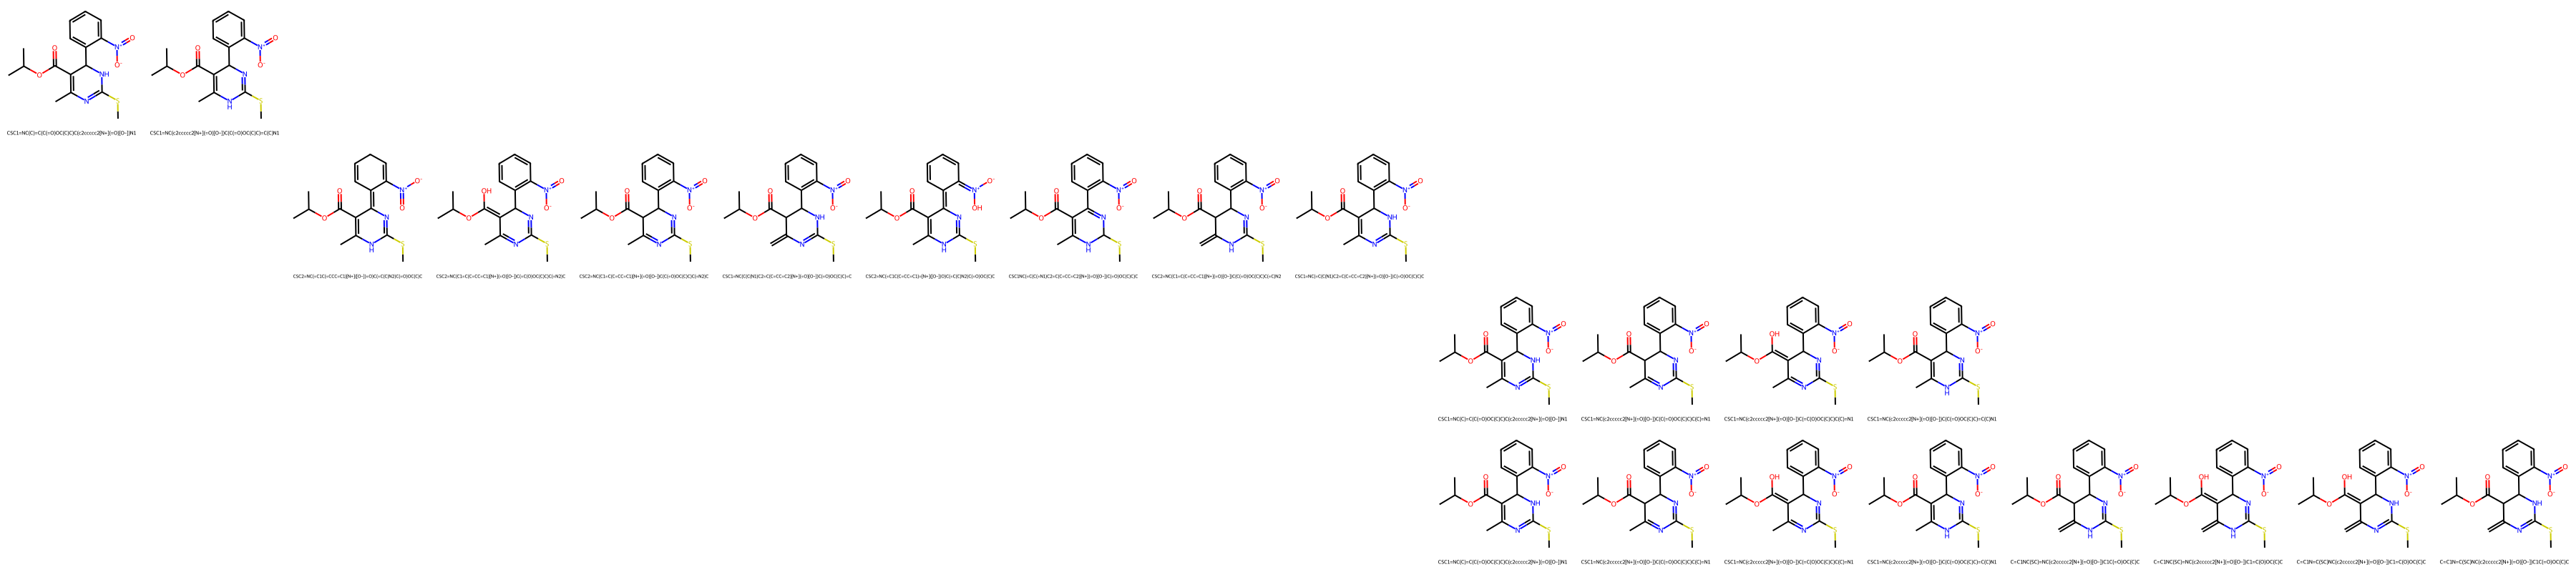

In [270]:
# Plot all four sets of tautomers
# Exclude blank entries to avoid problem with aligning structures based on maximum common substructure (mcs)
# smls_all_flat = smls_expt + smls_nih + smls_v2 + smls_v1
# tauts_all_flat = [Chem.MolFromSmiles(sml) for sml in smls_all_flat]
# print(len(tauts_all_flat))
# print(tauts_all_flat)

smls_matrix = [smls_expt, smls_nih_aligned, smls_v2_aligned, smls_v1_aligned]
tauts_matrix = [
    tauts_expt,
    tauts_nih_aligned,
    tauts_v2_aligned,
    tauts_v1_aligned,
]

tauts_all_flat = [item for sublist in tauts_matrix for item in sublist if item is not None]
print(tauts_all_flat)
mcs = rdFMCS.FindMCS(
    tauts_all_flat,
    bondCompare=rdFMCS.BondCompare.CompareAny,
)
mcs_smarts = mcs.smartsString
mcs_mol = Chem.MolFromSmarts(mcs_smarts)
Chem.Compute2DCoords(mcs_mol)
for m in tauts_all_flat:
    _ = Chem.GenerateDepictionMatching2DStructure(m, mcs_mol)

Draw.MolsMatrixToGridImage(
    tauts_matrix, 
    legendsMatrix=smls_matrix, 
    useSVG=True, 
    maxMols=200
)

In [226]:
# Optional--Checking data quality
df_1 = df.filter(pl.col("Ref")==1).select("Ref","Size",*numbered_columns[:4])
df_1
df_1_InChI = df_1.select("Ref",*InChI_columns[:2])
df_1_InChI = (
    df_1_InChI
    .melt(id_vars="Ref", value_vars=InChI_columns[:2], value_name="InChI")
    .select("InChI")
    .drop_nulls()
)
unique_InChI = set(df_1_InChI["InChI"].to_list())
print(f"{unique_InChI=}")

df_1_smls = df_1.select("Ref",*SMILES_columns[:2])

df_1_smls = (
    df_1_smls
    .melt(id_vars="Ref", value_vars=SMILES_columns[:2], value_name="sml")
    .select("sml")
    .drop_nulls()
)
unique_smls = df_1_smls["sml"].to_list()
unique_mols = [Chem.MolFromSmiles(sml) for sml in unique_smls]
unique_smls_canon = {Chem.MolToSmiles(mol) for mol in unique_mols}
unique_smls_to_inchi = {Chem.MolToInchi(mol) for mol in unique_mols}

print(f"{unique_smls_canon=}")
print(f"{unique_smls_to_inchi=}")

unique_InChI={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}
unique_smls_canon={'CC(=O)CC(C)=O', 'CC(=O)/C=C(/C)O'}
unique_smls_to_inchi={'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3H2,1-2H3', 'InChI=1S/C5H8O2/c1-4(6)3-5(2)7/h3,6H,1-2H3/b4-3-'}


Hi

In [227]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
smls_tauts
# check_same_keys(smls_tauts)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x175f05700>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x175f06e30>},
 {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol at 0x175f04270>,
  'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol at 0x175f07f40>}]

In [228]:
for i in range(0,1000):
    smls_tauts = enumerate_tauts(sml)

[{'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x157eb67a0>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x157eb6ff0>}, {'N=c1[nH]cc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x175f04740>, 'Nc1ncc[nH]1': <rdkit.Chem.rdchem.Mol object at 0x177255a80>}]
[['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1'], ['N=c1[nH]cc[nH]1', 'Nc1ncc[nH]1']]
[[<rdkit.Chem.rdchem.Mol object at 0x157eb67a0>, <rdkit.Chem.rdchem.Mol object at 0x157eb6ff0>], [<rdkit.Chem.rdchem.Mol object at 0x175f04740>, <rdkit.Chem.rdchem.Mol object at 0x177255a80>]]


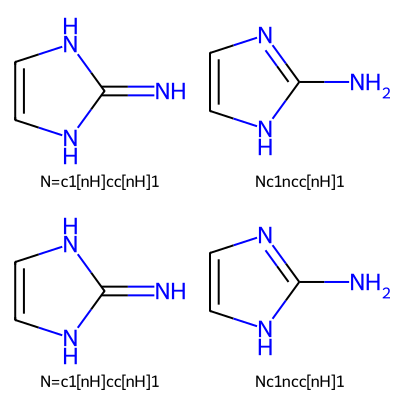

In [229]:
sml = "N=c1[nH]cc[nH]1"
smls_tauts = enumerate_tauts(sml)
print(smls_tauts)
smls = [[item for item in enumerator.keys()] for enumerator in smls_tauts]
tauts = [[item for item in enumerator.values()] for enumerator in smls_tauts]

print(smls)
print(tauts)
Draw.MolsMatrixToGridImage(tauts, legendsMatrix=smls)